# Prediction of bile predicaments

In [1]:
import pandas as pd

import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import train_test_split

import tensorflow_decision_forests as tfdf

import dtreeviz

from matplotlib import pyplot as plt
from IPython import display

# avoid "Arial font not found warnings"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

display.set_matplotlib_formats('retina') # generate hires plots

np.random.seed(1234)  # reproducible plots_data for explanatory reasons

2023-12-18 01:29:39.222840: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 01:29:39.246586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 01:29:39.246616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 01:29:39.247335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 01:29:39.251655: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 01:29:39.252340: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Get & clean data

### Load and inspect

In [2]:
df_idc = pd.read_excel("data/Intraductal_concrement.xlsx", sheet_name=0, skiprows=1, header=None)
df_idc_visits = pd.read_excel("data/Intraductal_concrement.xlsx", sheet_name=0, skiprows=0, header=None)
df_idc.columns = df_idc_visits.iloc[0] + '_' + df_idc.iloc[0]
df_idc.columns = df_idc.columns.str.lower()
df_idc.insert(2, 'has_idc', "1")
df_idc.drop(index=0, inplace=True)

In [3]:
df_idc.iloc[:, 2:]

,has_idc,baseline_characteristics_etiology,baseline_characteristics_admission_date,baseline_characteristics_age,baseline_characteristics_sex,baseline_characteristics_height_in_cm,baseline_characteristics_weight_in_kg,baseline_characteristics_bmi,baseline_characteristics_medical_history,baseline_characteristics_medication_at_admission,...,abdominal_sonography_size_of_smallest_concrement,abdominal_sonography_size_of_biggest_concrement,abdominal_sonography_ultrasound_behaviour,eus_ercp_mrcp_or_as_dhc_width_in_mm,NaN,eus_ercp_mrcp_or_as_intrahepatic_bile_duct_width_in_mm,NaN,NaN,ct/mri_date,ct/mri_special_report?
1,1,biliary,2012-04-07 00:00:00,91,f,unknown,unknown,unknown,"1,4,5,9","1,2,4",...,NaN,NaN,NaN,8,EUS,NaN,NaN,CT,2012-04-07 00:00:00,peripancreatic_fluid
2,1,biliary,2010-05-18 00:00:00,68,f,176,74,23.9,5,0,...,NaN,NaN,NaN,15,ERCP,NaN,NaN,NaN,NaN,NaN
3,1,biliary,2006-10-15 00:00:00,72,f,160,72,28.1,"1,4,7,9","1,2,3,4",...,NaN,NaN,NaN,15,CT,NaN,NaN,CT,2006-10-16 00:00:00,no_concrements
4,1,biliary,2006-10-01 00:00:00,66,f,165,52,19.1,"1,3,9","1,2,4,8",...,NaN,NaN,NaN,15,ERCP,NaN,NaN,NaN,NaN,NaN
5,1,biliary,2021-02-08 00:00:00,81,f,172,74,25,1.9,2.7,...,NaN,NaN,NaN,12,AS,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,biliary,2006-04-28 00:00:00,69,m,169,75,26.3,"3,4,7,8,9",1.2,...,NaN,2.5,hyperechoic_with_acoustic_shadowing,8,AS,NaN,NaN,CT,2006-04-28 00:00:00,perpancreatic_fluid;no_concrements
164,1,biliary,2018-10-29 00:00:00,65,f,161,73,28.2,0,0,...,NaN,6,hyperechoic_with_acoustic_shadowing,9.5,EUS,NaN,NaN,CT,2018-10-29 00:00:00,GB:_41x27mm_concrement+15-20_concrements_about...
165,1,biliary,2017-12-01 00:00:00,60,m,176,115,37.1,9,1.2,...,NaN,5,unknown,11,AS,NaN,NaN,CT,2017-12-02 00:00:00,2_small_concrements_in_GB;peripancreatic_fluid
166,1,biliary,2018-12-29 00:00:00,54,f,156,81,33.3,9,unknown,...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,CT,2018-12-30 00:00:00,concrements_and_sludge_in_DHC


In [4]:
df_idc.columns.tolist()[:10]

['baseline_characteristics_patient_number',
 'baseline_characteristics_case',
 'has_idc',
 'baseline_characteristics_etiology',
 'baseline_characteristics_admission_date',
 'baseline_characteristics_age',
 'baseline_characteristics_sex',
 'baseline_characteristics_height_in_cm',
 'baseline_characteristics_weight_in_kg',
 'baseline_characteristics_bmi']

In [5]:
df_no_idc = pd.read_excel("data/No_intraductal_concrement.xlsx", sheet_name=0, skiprows=1, header=None)
df_no_idc_visits = pd.read_excel("data/No_intraductal_concrement.xlsx", sheet_name=0, skiprows=0, header=None)
df_no_idc.columns = df_no_idc_visits.iloc[0] + '_' + df_no_idc.iloc[0]
df_no_idc.columns = df_no_idc.columns.str.lower()
df_no_idc.insert(2, 'has_idc', "0")
df_no_idc.drop(index=0, inplace=True)

In [6]:
df_no_idc.iloc[:, 2:]

,has_idc,baseline_characteristics_etiology,baseline_characteristics_admission_date,baseline_characteristics_age,baseline_characteristics_sex,baseline_characteristics_height_in_cm,baseline_characteristics_weight_in_kg,baseline_characteristics_bmi,baseline_characteristics_medical_history,baseline_characteristics_medication_at_admission,...,abdominal_sonography_size_of_smallest_concrement,abdominal_sonography_size_of_biggest_concrement,abdominal_sonography_ultrasound_behaviour,eus_ercp_mrcp_or_as_dhc_width_in_mm,NaN,eus_ercp_mrcp_or_as_intrahepatic_bile_duct_width_in_mm,NaN,NaN,ct/mri_date,ct/mri_special_report?
1,0,biliary,2006-11-21 00:00:00,69,m,177,76,24.3,8,0,...,unknown,unknown,hyperechoic_with_acoustic_shadowing,unknown,NaN,NaN,NaN,CT,2006-11-21 00:00:00,"2-3_concrements_(ca.0,6cm)_in_the_GB"
2,0,biliary,2017-07-23 00:00:00,81,f,160,84.6,33.2,9,"1,2,8",...,NaN,16,hyperechoic_with_acoustic_shadowing,9,EUS,NaN,NaN,NaN,NaN,NaN
3,0,biliary,2006-05-14 00:00:00,67,f,166,70,25.4,2.5,0,...,22,30,hyperechoic_with_acoustic_shadowing,10,CT,NaN,NaN,CT,2006-05-14 00:00:00,concrements_in_the_GB;peripancreatic_adipose_t...
4,0,biliary,2016-01-21 00:00:00,80,m,165,70,25.7,"1,4,7,9","1,2,3",...,NaN,NaN,NaN,13,ERCP,NaN,NaN,CT,2016-01-21 00:00:00,"prepapillary_concrement_ca.8,5mm"
5,0,biliary,2020-12-25 00:00:00,87,f,163,86,32.4,"4,5,8,9","1,2,3,4",...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,CT,2020-12-30 00:00:00,GB_not_mentioned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0,biliary,2013-04-29 00:00:00,43,m,183,93,27.8,5,1,...,NaN,6,unknown,5,AS,NaN,NaN,CT,2013-04-29 00:00:00,no_concrements
178,0,biliary,2012-01-22 00:00:00,83,m,180,85,26.2,9,2.3,...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN
179,0,biliary,2018-08-24 00:00:00,55,f,161,66.3,25.6,0,1.2,...,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN
180,0,biliary,2011-12-23 00:00:00,49,m,180,86,26.5,0,0,...,unknown,unknown,hyperechoic_with_acoustic_shadowing,15,MRCP,NaN,NaN,NaN,NaN,NaN


In [7]:
df_no_idc.columns.tolist()[:10]

['baseline_characteristics_patient_number',
 'baseline_characteristics_case',
 'has_idc',
 'baseline_characteristics_etiology',
 'baseline_characteristics_admission_date',
 'baseline_characteristics_age',
 'baseline_characteristics_sex',
 'baseline_characteristics_height_in_cm',
 'baseline_characteristics_weight_in_kg',
 'baseline_characteristics_bmi']

### Check that column names are identical

In [8]:
assert(df_idc.columns.tolist() == df_no_idc.columns.tolist())

### Join the data frames

In [9]:
input_data = pd.concat([df_idc, df_no_idc])

### Clean and format

In [10]:
input_data.replace(['unknown', 'missing', 'ns', ' ns', "ms", "s", "sn"], np.nan, inplace=True)
lab_cols = input_data.filter(like='lab_values').columns
input_data[lab_cols] = input_data[lab_cols].replace(',', '.', regex=True)
input_data[lab_cols] = input_data[lab_cols].replace(['.*\\.\\..*', '.*\\.\\.\\..*'], pd.NA, regex=True)
input_data[lab_cols] = input_data[lab_cols].replace('ß', '0', regex=True)
input_data[lab_cols] = input_data[lab_cols].replace('.', np.nan)
input_data[lab_cols] = input_data[lab_cols].replace('n2.23', np.nan)

In [11]:
input_data[['ercp_date', 'baseline_characteristics_admission_date']] = input_data[['ercp_date', 'baseline_characteristics_admission_date']].replace(['.*\\.\\..*', '.*\\.\\.\\..*'], pd.NA, regex=True)

input_data = input_data.convert_dtypes()
input_data[lab_cols] = input_data[lab_cols].astype('float64')

# Add column if ercp_date was within 3 days of admission baseline_characteristics_admission_date
input_data['ercp_date'] = pd.to_datetime(input_data['ercp_date'])
input_data['baseline_characteristics_admission_date'] = pd.to_datetime(input_data['baseline_characteristics_admission_date'])
input_data['ercp_date_minus_admission_date'] = input_data['ercp_date'] - input_data['baseline_characteristics_admission_date']
input_data['ecrp_gte_3_days_naT'] = input_data['ercp_date_minus_admission_date'] >= pd.Timedelta(days=3) 
input_data['ercp_date_na'] = input_data['ercp_date'].isna()
input_data['ecrp_gte_3_days'] =  input_data['ercp_date_na'] | input_data['ecrp_gte_3_days_naT']

# Rename column names of input_data
input_data.columns = input_data.columns.str.replace('/', '_')
input_data.columns = input_data.columns.str.replace(' ', '')

In [12]:

input_data.iloc[:, 2:]

,has_idc,baseline_characteristics_etiology,baseline_characteristics_admission_date,baseline_characteristics_age,baseline_characteristics_sex,baseline_characteristics_height_in_cm,baseline_characteristics_weight_in_kg,baseline_characteristics_bmi,baseline_characteristics_medical_history,baseline_characteristics_medication_at_admission,...,NaN,eus_ercp_mrcp_or_as_intrahepatic_bile_duct_width_in_mm,NaN,NaN,ct_mri_date,ct_mri_special_report?,ercp_date_minus_admission_date,ecrp_gte_3_days_naT,ercp_date_na,ecrp_gte_3_days
1,1,biliary,2012-04-07,91,f,<NA>,NaN,<NA>,"1,4,5,9","1,2,4",...,EUS,<NA>,<NA>,CT,2012-04-07 00:00:00,peripancreatic_fluid,13 days,True,False,True
2,1,biliary,2010-05-18,68,f,176,74,23.9,5,0,...,ERCP,<NA>,<NA>,<NA>,NaN,<NA>,0 days,False,False,False
3,1,biliary,2006-10-15,72,f,160,72,28.1,"1,4,7,9","1,2,3,4",...,CT,<NA>,<NA>,CT,2006-10-16 00:00:00,no_concrements,2 days,False,False,False
4,1,biliary,2006-10-01,66,f,165,52,19.1,"1,3,9","1,2,4,8",...,ERCP,<NA>,<NA>,<NA>,NaN,<NA>,2 days,False,False,False
5,1,biliary,2021-02-08,81,f,172,74,25.0,1.9,2.7,...,AS,<NA>,<NA>,<NA>,NaN,<NA>,1 days,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0,biliary,2013-04-29,43,m,183,93,27.8,5,1,...,AS,<NA>,<NA>,CT,2013-04-29 00:00:00,no_concrements,NaT,False,True,True
178,0,biliary,2012-01-22,83,m,180,85,26.2,9,2.3,...,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,NaT,False,True,True
179,0,biliary,2018-08-24,55,f,161,66.3,25.6,0,1.2,...,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,NaT,False,True,True
180,0,biliary,2011-12-23,49,m,180,86,26.5,0,0,...,MRCP,<NA>,<NA>,<NA>,NaN,<NA>,NaT,False,True,True


### Write data to csv for external analysis

In [13]:
input_data_tab1 = input_data.copy()
input_data_tab1.loc[:, 'has_idc'] = input_data_tab1['has_idc'].astype('category')
input_data_tab1.to_csv("data/input_data_tab1.csv", index=False)

## Prepare data for TFDF: BASELINE

### Features

In [14]:
TARGET_COLUMN_NAME = ["has_idc"]

ECRP_GTE_3_DAYS = ["ecrp_gte_3_days"]

DATA_HEADER = input_data.columns

CATEGORICAL_FEATURE_NAMES = [
                            'baseline_characteristics_sex', 
                            'baseline_characteristics_nicotine_use',
                            #'baseline_characteristics_alcohol_use',
                            ]

NUMERIC_BASELINE_FEATURE_NAMES = [
                            'baseline_characteristics_age',
                            'baseline_characteristics_height_in_cm',
                            'baseline_characteristics_weight_in_kg',
                            # 'baseline_characteristics_bmi',
                             #'eus_ercp_mrcp_or_as_dhc_width_in_mm'
                            ]

# NUMERIC_LAB_FEATURE_NAMES_ADMISSION = input_data.filter(like='lab_values_admission').columns.tolist()
# Remove variables with mostly missing values
NUMERIC_LAB_FEATURE_NAMES_ADMISSION =['lab_values_admission_crp_in_mg_dl',
                                    #'lab_values_admission_pct_in_ng_ml',
                                    #'lab_values_admission_il6_in_pg_ml',
                                    'lab_values_admission_leukocytes_in_g_l',
                                    'lab_values_admission_bilirubin_in_mg_dl',
                                    'lab_values_admission_got_ast_in_u_l',
                                    'lab_values_admission_gpt_alt_in_u_l',
                                    'lab_values_admission_gamma-gt_in_u_l',
                                    'lab_values_admission_alkaline_phosphatase_in_u_l',
                                    #'lab_values_admission_lipase_in_u_l',
                                    #'lab_values_admission_inr',
                                    # 'lab_values_admission_quick _in_%',
                                    'lab_values_admission_calcium_in_mmol_l',
                                    # 'lab_values_admission_calcium_alb.-corrected_mmol_l',
                                    'lab_values_admission_triglycerides_in_mg_dl',
                                    'lab_values_admission_hematocrit',
                                    #'lab_values_admission_gfr_in_ml_min',
                                    'lab_values_admission_creatinine_in_mg_dl',
                                    #'lab_values_admission_urea_in_mg_dl',
                                    #'lab_values_admission_igg4_in_g_l'
                                    ]
# Fix names for use in model

# NUMERIC_LAB_FEATURE_NAMES_DAY3 = input_data.filter(like='lab_values_day_3').columns.tolist()

NUMERIC_LAB_FEATURE_NAMES_DAY3 = ['lab_values_day_3_crp_in_mg_dl',
                                #'lab_values_day_3_pct_in_ng_ml',
                                #'lab_values_day_3_il6_in_pg_ml',
                                #'lab_values_day_3_leukocytes_in_g_l',
                                'lab_values_day_3_bilirubin_in_mg_dl',
                                'lab_values_day_3_got_ast_in_u_l',
                                'lab_values_day_3_gpt_alt_in_u_l',
                                'lab_values_day_3_gamma-gt_in_u_l',
                                'lab_values_day_3_alkaline_phosphatase_in_u_l',
                                #'lab_values_day_3_lipase_in_u_l',
                                #'lab_values_day_3_inr',
                                #'lab_values_day_3_quick _in_%',
                                #'lab_values_day_3_calcium_in_mmol_l',
                                #'lab_values_day_3_calcium_alb.-corrected_mmol_l',
                                'lab_values_day_3_triglycerides_in_mg_dl',
                                'lab_values_day_3_hematocrit',
                                #'lab_values_day_3_gfr_in_ml_min',
                                'lab_values_day_3_creatinine_in_mg_dl',
                                #'lab_values_day_3_urea_in_mg_dl'
                                ]

NUMERIC_FEATURE_NAMES_ALL = NUMERIC_BASELINE_FEATURE_NAMES + NUMERIC_LAB_FEATURE_NAMES_ADMISSION + NUMERIC_LAB_FEATURE_NAMES_DAY3
ALL_FEATURE_NAMES_ADMISSION = TARGET_COLUMN_NAME + CATEGORICAL_FEATURE_NAMES + NUMERIC_BASELINE_FEATURE_NAMES + NUMERIC_LAB_FEATURE_NAMES_ADMISSION
ALL_FEATURE_NAMES_DAY3 = TARGET_COLUMN_NAME + CATEGORICAL_FEATURE_NAMES + NUMERIC_BASELINE_FEATURE_NAMES + NUMERIC_LAB_FEATURE_NAMES_DAY3

### Select and convert data types

In [15]:
x_data = pd.DataFrame()

x_data_pre = input_data.copy()

x_data[TARGET_COLUMN_NAME] = x_data_pre[TARGET_COLUMN_NAME].astype('int')

x_data[CATEGORICAL_FEATURE_NAMES] = x_data_pre[CATEGORICAL_FEATURE_NAMES].fillna('').astype('category')
if len(CATEGORICAL_FEATURE_NAMES) > 0:
    x_data[CATEGORICAL_FEATURE_NAMES] = x_data[CATEGORICAL_FEATURE_NAMES].apply(lambda x: x.cat.codes).astype('int64')

x_data[NUMERIC_FEATURE_NAMES_ALL]= x_data_pre[NUMERIC_FEATURE_NAMES_ALL].fillna(float(np.nan)).astype('float64')

x_data[ECRP_GTE_3_DAYS] = x_data_pre[ECRP_GTE_3_DAYS].astype('bool')

x_data['dhc_in_mm'] = x_data_pre['eus_ercp_mrcp_or_as_dhc_width_in_mm']
x_data['clinical_data_stone_microlithiasis_sludge'] = x_data_pre['clinical_data_stone_microlithiasis_sludge']

x_data.dtypes

has_idc                                               int64
baseline_characteristics_sex                          int64
baseline_characteristics_nicotine_use                 int64
baseline_characteristics_age                        float64
baseline_characteristics_height_in_cm               float64
baseline_characteristics_weight_in_kg               float64
lab_values_admission_crp_in_mg_dl                   float64
lab_values_admission_leukocytes_in_g_l              float64
lab_values_admission_bilirubin_in_mg_dl             float64
lab_values_admission_got_ast_in_u_l                 float64
lab_values_admission_gpt_alt_in_u_l                 float64
lab_values_admission_gamma-gt_in_u_l                float64
lab_values_admission_alkaline_phosphatase_in_u_l    float64
lab_values_admission_calcium_in_mmol_l              float64
lab_values_admission_triglycerides_in_mg_dl         float64
lab_values_admission_hematocrit                     float64
lab_values_admission_creatinine_in_mg_dl

### Split data in training and test data

In [16]:
train_df, test_df = train_test_split(x_data, test_size=0.2, random_state=42)

test_df_ecrp_gte_3_days = test_df[ECRP_GTE_3_DAYS]

test_df_pandas = test_df.copy()

# remove pass_dhc_col from test_df
test_df = test_df.drop(columns=['dhc_in_mm'])
train_df = train_df.drop(columns=['dhc_in_mm'])
test_df = test_df.drop(columns=['clinical_data_stone_microlithiasis_sludge'])

test_df_copy = test_df.copy()


test_labels = test_df_copy[TARGET_COLUMN_NAME].values
test_df_d3 = test_df_copy[ALL_FEATURE_NAMES_DAY3]
test_df_d3.columns = test_df_d3.columns.str.replace('baseline_characteristics_', '')
test_df_d3.columns = test_df_d3.columns.str.replace('lab_values_day_3_', '')
model_cols = test_df_d3.columns
test_df_d32 = test_df_d3.copy()



### Write model columns to csv

In [17]:
model_cols_df = pd.DataFrame()
model_cols_df['model_cols'] = model_cols
model_cols_df['dtypes'] = test_df_d32.dtypes.astype('str').tolist()

# Write to csv
model_cols_df.to_csv("data/model_cols_df.csv", index=False)

#### Make train tf-dataset

In [18]:
train_df

,has_idc,baseline_characteristics_sex,baseline_characteristics_nicotine_use,baseline_characteristics_age,baseline_characteristics_height_in_cm,baseline_characteristics_weight_in_kg,lab_values_admission_crp_in_mg_dl,lab_values_admission_leukocytes_in_g_l,lab_values_admission_bilirubin_in_mg_dl,lab_values_admission_got_ast_in_u_l,...,lab_values_day_3_bilirubin_in_mg_dl,lab_values_day_3_got_ast_in_u_l,lab_values_day_3_gpt_alt_in_u_l,lab_values_day_3_gamma-gt_in_u_l,lab_values_day_3_alkaline_phosphatase_in_u_l,lab_values_day_3_triglycerides_in_mg_dl,lab_values_day_3_hematocrit,lab_values_day_3_creatinine_in_mg_dl,ecrp_gte_3_days,clinical_data_stone_microlithiasis_sludge
11,0,1,0,48.0,182.0,84.0,1.50,4.76,0.3,203.0,...,1.4,242.0,663.0,480.0,254.0,NaN,0.398,0.9,True,1
79,1,1,0,79.0,NaN,NaN,1.70,12.50,6.1,229.0,...,3.7,247.0,NaN,250.0,172.0,NaN,0.364,1.2,False,1
91,1,0,3,53.0,170.0,93.0,1.00,7.59,3.0,1545.0,...,1.6,701.0,1264.0,689.0,253.0,NaN,0.366,0.6,False,2
17,1,0,4,43.0,NaN,NaN,14.00,15.10,9.2,420.0,...,6.0,214.0,209.0,NaN,164.0,NaN,0.340,0.8,False,1
67,1,1,3,51.0,180.0,80.0,4.40,15.00,5.0,176.0,...,2.6,84.0,353.0,320.0,91.0,NaN,0.441,0.8,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,0,0,0,34.0,160.0,59.0,0.40,6.23,4.0,1101.0,...,1.0,125.0,656.0,299.0,235.0,NaN,0.347,0.7,True,1
72,1,0,0,81.0,NaN,NaN,6.20,12.60,0.7,18.0,...,1.1,21.0,18.0,109.0,102.0,NaN,0.347,2.0,True,7
107,1,1,3,92.0,165.0,50.0,0.99,13.60,5.3,272.0,...,8.2,195.0,203.0,1101.0,763.0,NaN,0.329,1.3,False,3
104,0,0,0,78.0,162.0,88.0,22.70,11.50,4.8,556.0,...,5.3,203.0,197.0,577.0,413.0,NaN,0.337,0.9,True,4


In [19]:
train_df = train_df[ALL_FEATURE_NAMES_ADMISSION + ["clinical_data_stone_microlithiasis_sludge"]]
train_df.columns = train_df.columns.str.replace('baseline_characteristics_', '')
train_df.columns = train_df.columns.str.replace('lab_values_admission_', '')
#train_df = train_df[model_cols + ["clinical_data_stone_microlithiasis_sludge"]]

train_df.dtypes


has_idc                                        int64
sex                                            int64
nicotine_use                                   int64
age                                          float64
height_in_cm                                 float64
weight_in_kg                                 float64
crp_in_mg_dl                                 float64
leukocytes_in_g_l                            float64
bilirubin_in_mg_dl                           float64
got_ast_in_u_l                               float64
gpt_alt_in_u_l                               float64
gamma-gt_in_u_l                              float64
alkaline_phosphatase_in_u_l                  float64
calcium_in_mmol_l                            float64
triglycerides_in_mg_dl                       float64
hematocrit                                   float64
creatinine_in_mg_dl                          float64
clinical_data_stone_microlithiasis_sludge      Int64
dtype: object

In [20]:
select_cols = model_cols 
select_cols = select_cols.append(pd.Index(["clinical_data_stone_microlithiasis_sludge"]))

train_df = train_df[select_cols]


### Impute missing values
Uses the MICE algorithm.

In [21]:

# Impute training data
imputer = IterativeImputer(random_state=41)
imputed = imputer.fit_transform(train_df)
df_imputed = pd.DataFrame(imputed, columns=train_df.columns)

df_imputed['has_idc'] = df_imputed['has_idc'].astype('int64')

train_df_pd = df_imputed.copy()



/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


### Oversample minority classes (sludge and microlithiasis)

In [22]:
# Define minortiy class
is_sl_or_mic = df_imputed['clinical_data_stone_microlithiasis_sludge'].isin([2, 3, 6])
is_sl_or_mic = is_sl_or_mic.astype('int64')

In [23]:
from imblearn.over_sampling import SMOTE
# Oversample the minority class using the SMOTE algorithm

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
train_df_oversampled, y_train_oversampled = smote.fit_resample(df_imputed, is_sl_or_mic)

print("Before oversampling" + str(df_imputed.shape) + "; after oversampling:" + str(train_df_oversampled.shape))


Before oversampling(278, 16); after oversampling:(304, 16)


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

### Convert to tf dataset

In [24]:
train_df = train_df_oversampled[model_cols]
train_df["sex"] = train_df["sex"].astype('int64')
train_df["nicotine_use"] = train_df["nicotine_use"].astype('int64')

train_cols = train_df.dtypes
train_df = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="has_idc")


/tmp/ipykernel_67957/770190344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_67957/770190344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Make test tf-dataset

In [25]:
test_labels = test_df[TARGET_COLUMN_NAME].values
test_df = test_df[ALL_FEATURE_NAMES_ADMISSION]
test_df.columns = test_df.columns.str.replace('baseline_characteristics_', '')
test_df.columns = test_df.columns.str.replace('lab_values_admission_', '')
test_df = test_df[model_cols]
test_cols = test_df.dtypes
test_df = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="has_idc")

In [26]:
train_cols == test_cols

has_idc                        True
sex                            True
nicotine_use                   True
age                            True
height_in_cm                   True
weight_in_kg                   True
crp_in_mg_dl                   True
bilirubin_in_mg_dl             True
got_ast_in_u_l                 True
gpt_alt_in_u_l                 True
gamma-gt_in_u_l                True
alkaline_phosphatase_in_u_l    True
triglycerides_in_mg_dl         True
hematocrit                     True
creatinine_in_mg_dl            True
dtype: bool

In [27]:
test_cols

has_idc                          int64
sex                              int64
nicotine_use                     int64
age                            float64
height_in_cm                   float64
weight_in_kg                   float64
crp_in_mg_dl                   float64
bilirubin_in_mg_dl             float64
got_ast_in_u_l                 float64
gpt_alt_in_u_l                 float64
gamma-gt_in_u_l                float64
alkaline_phosphatase_in_u_l    float64
triglycerides_in_mg_dl         float64
hematocrit                     float64
creatinine_in_mg_dl            float64
dtype: object

## Train the model - random forests BASELINE

In [28]:
# Crete a tuner for model optimization on sensitivity (i.e. has_idc=1)

# model_rf = tfdf.keras.GradientBoostedTreesModel()
model_rf = tfdf.keras.RandomForestModel(
    #tuner=tuner,
    compute_oob_variable_importances=True,
    )
model_rf.fit(train_df)

Use /tmp/tmp88js3g09 as temporary training directory
Reading training dataset...


Training dataset read in 0:00:03.153313. Found 304 examples.
Training model...
Model trained in 0:00:00.094286
Compiling model...


[INFO 23-12-18 01:29:45.7055 UTC kernel.cc:1233] Loading model from path /tmp/tmp88js3g09/model/ with prefix cdb89bf1952d42ff
[INFO 23-12-18 01:29:45.7251 UTC decision_forest.cc:660] Model loaded with 300 root(s), 20424 node(s), and 14 input feature(s).
[INFO 23-12-18 01:29:45.7251 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-12-18 01:29:45.7251 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


### Evaluate the model
We adjust the threshold to 0.25 for sensitivity.

In [29]:
model_rf.compile(metrics=["accuracy", "AUC", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])

1/1 [==============================] - 0s 34ms/step


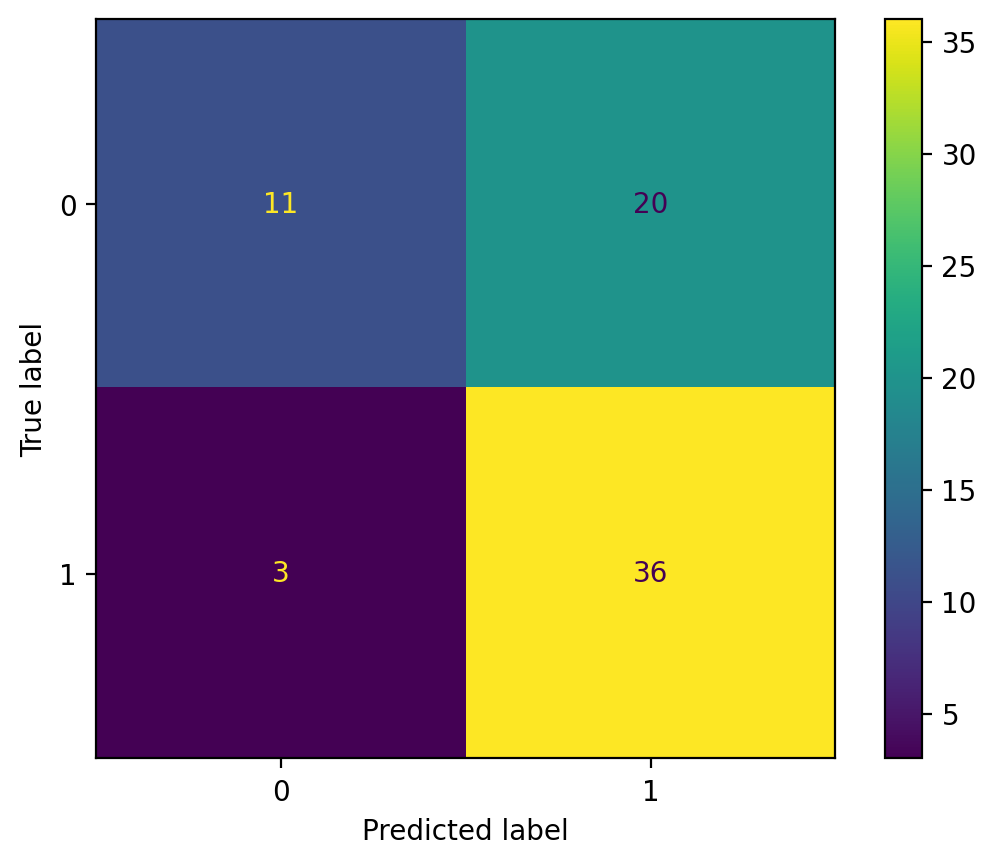

In [30]:
probs = model_rf.predict(test_df)
preds = probs > 0.25

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(test_labels, preds)

import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, preds)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

**Figure.** Confusion matrix for the test set: True positives (TP), true negatives (TN), false positives (FP), false negatives (FN).

In [31]:
# Write data for analysis in R to csv
test_df_pandas['pred_prob'] = probs
test_df_pandas['pred_idc'] = preds
test_df_pandas.to_csv("data/test_df_pandas.csv", index=False)

In [32]:
evaluation = model_rf.evaluate(test_df, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 660ms/step - loss: 0.0000e+00 - accuracy: 0.6714 - auc: 0.7382 - true_positives: 20.0000 - true_negatives: 27.0000 - false_positives: 4.0000 - false_negatives: 19.0000
loss: 0.0000
accuracy: 0.6714
auc: 0.7382
true_positives: 20.0000
true_negatives: 27.0000
false_positives: 4.0000
false_negatives: 19.0000


#### Inspect the model

In [33]:
print(model_rf.summary())

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (14):
	age
	alkaline_phosphatase_in_u_l
	bilirubin_in_mg_dl
	creatinine_in_mg_dl
	crp_in_mg_dl
	gamma-gt_in_u_l
	got_ast_in_u_l
	gpt_alt_in_u_l
	height_in_cm
	hematocrit
	nicotine_use
	sex
	triglycerides_in_mg_dl
	weight_in_kg

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                         "age"  0.247574 ################
    2.             "gamma-gt_in_u_l"  0.223683 ############
    3. "alkaline_phosphatase_in_u_l"  0.201435 #########
    4.                "crp_in_mg_dl"  0.172082 ######
    5.          "bilirubin_in_mg_dl"  0.171010 #####
    6.                "weight_in

In [34]:
inspector = model_rf.make_inspector()

inspector.evaluation()



Evaluation(num_examples=304, accuracy=0.6151315789473685, loss=0.6892987939676172, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [35]:
# Print all the variable importances
model_rf.summary()

# List the available variable importances
print(inspector.variable_importances().keys())

# Show a specific variable importance
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["MEAN_DECREASE_IN_ACCURACY"]


Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (14):
	age
	alkaline_phosphatase_in_u_l
	bilirubin_in_mg_dl
	creatinine_in_mg_dl
	crp_in_mg_dl
	gamma-gt_in_u_l
	got_ast_in_u_l
	gpt_alt_in_u_l
	height_in_cm
	hematocrit
	nicotine_use
	sex
	triglycerides_in_mg_dl
	weight_in_kg

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                         "age"  0.247574 ################
    2.             "gamma-gt_in_u_l"  0.223683 ############
    3. "alkaline_phosphatase_in_u_l"  0.201435 #########
    4.                "crp_in_mg_dl"  0.172082 ######
    5.          "bilirubin_in_mg_dl"  0.171010 #####
    6.                "weight_in

[("gamma-gt_in_u_l" (1; #6), 0.039473652839660645),
 ("bilirubin_in_mg_dl" (1; #3), 0.019736826419830322),
 ("got_ast_in_u_l" (1; #7), 0.013157844543457031),
 ("hematocrit" (1; #10), 0.013157844543457031),
 ("weight_in_kg" (1; #14), 0.013157844543457031),
 ("alkaline_phosphatase_in_u_l" (1; #2), 0.009868383407592773),
 ("triglycerides_in_mg_dl" (1; #13), 0.009868383407592773),
 ("age" (1; #1), 0.006578922271728516),
 ("gpt_alt_in_u_l" (1; #8), 0.006578922271728516),
 ("nicotine_use" (1; #11), 0.0),
 ("sex" (1; #12), 0.0),
 ("height_in_cm" (1; #9), -0.003289520740509033),
 ("creatinine_in_mg_dl" (1; #4), -0.016447365283966064),
 ("crp_in_mg_dl" (1; #5), -0.023026347160339355)]

In [36]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)


Available variable importances:
	 SUM_SCORE
	 MEAN_DECREASE_IN_ACCURACY
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS
	 NUM_NODES
	 NUM_AS_ROOT
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS
	 INV_MEAN_MIN_DEPTH


#### Plot feature importance
Report feature importance as Inverse mean minimum depth (INV_MEAN_MIN_DEPTH).


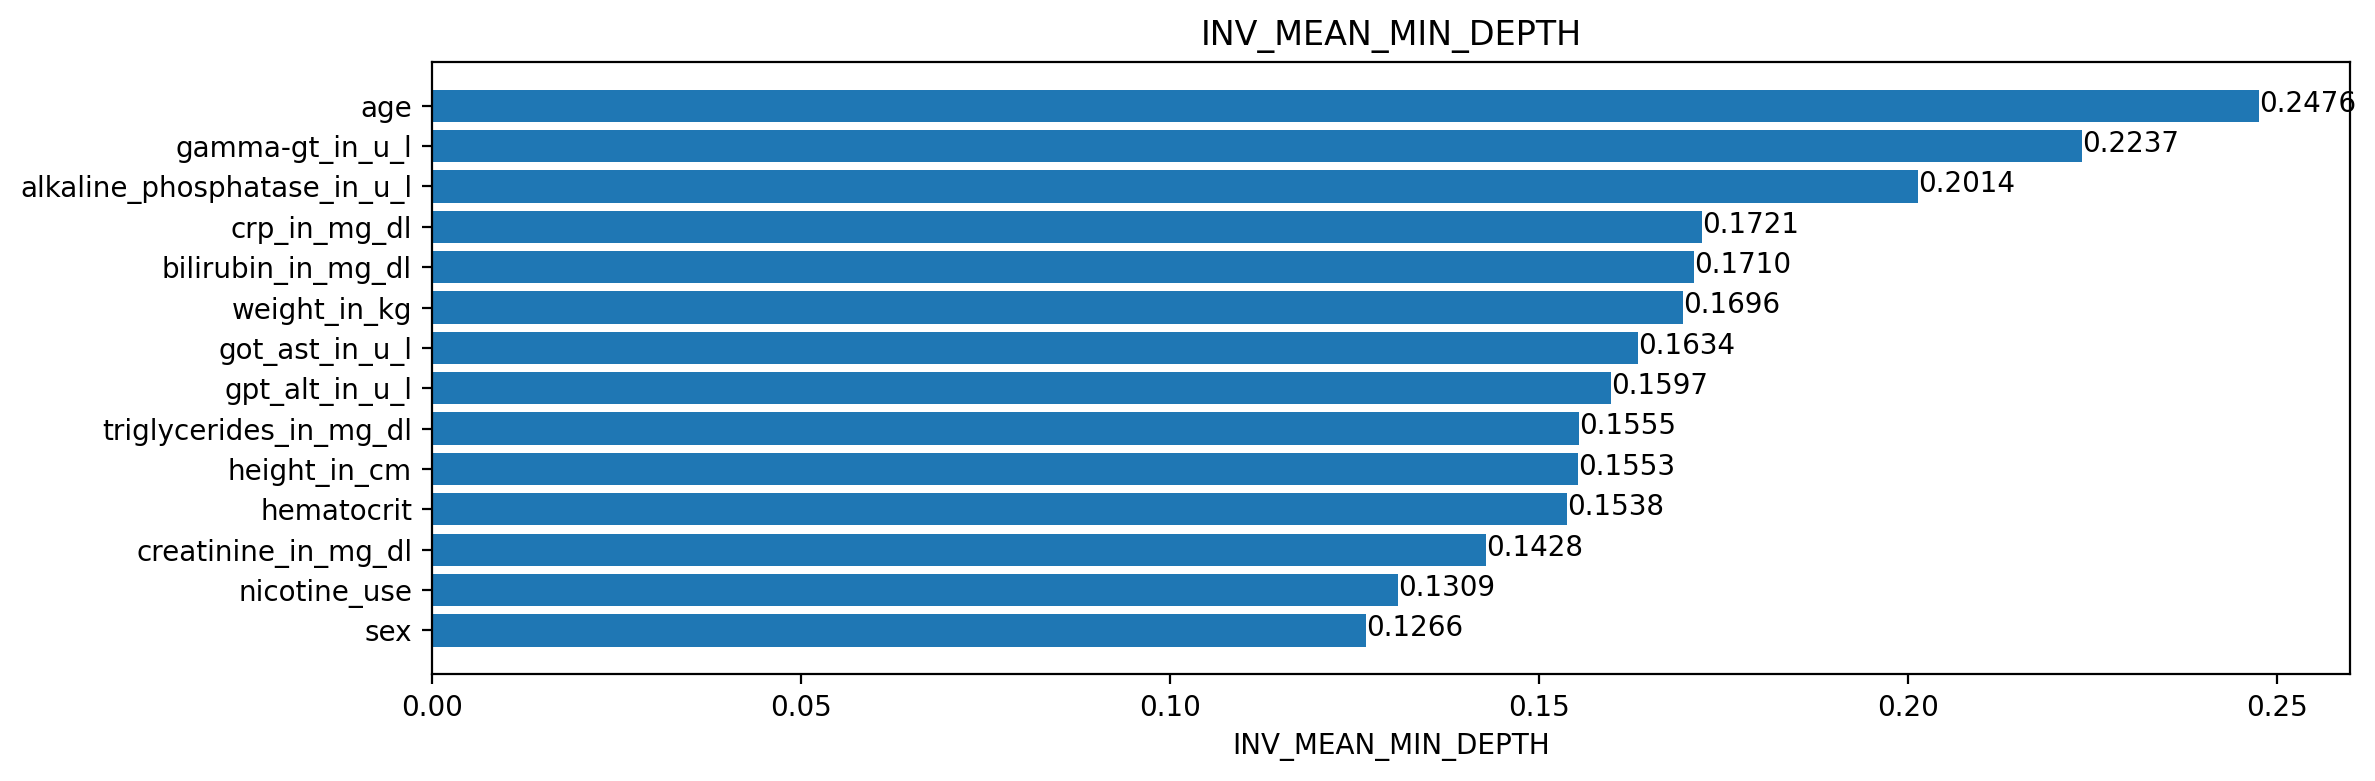

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "INV_MEAN_MIN_DEPTH"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("INV_MEAN_MIN_DEPTH")
plt.tight_layout()
plt.show()


### Write feature importances to csv

In [38]:
df = pd.DataFrame()
df['feature_names'] = feature_names
df['feature_importances'] = feature_importances
df['feature_ranks'] = feature_ranks
df['variable_importance_metric'] = variable_importance_metric

# Add feature type (numeric or categorical) by checing, if feature name is in part in CATEGORICAL_FEATURE_NAMES
df['feature_type'] = 'numeric'
df['feature_type'] = np.where(df['feature_names'].str.contains('|'.join(CATEGORICAL_FEATURE_NAMES)), 'categorical', 'numeric')
# check for each name in df['feature_names'] if it is a substring of CATEGORICAL_FEATURE_NAMES
for i in df['feature_names']:
    i in ('|'.join(CATEGORICAL_FEATURE_NAMES))
    if i in ('|'.join(CATEGORICAL_FEATURE_NAMES)):
        df.loc[df['feature_names'] == i, 'feature_type'] = 'categorical'
df.to_csv("data/feature_importances.csv", index=False)

#### Plot the model

In [39]:
# Tell dtreeviz about training data and model
model_features = [f.name for f in model_rf.make_inspector().features()]

model_features
classes = [0, 1]

train_df_pd['has_idc'] = train_df_pd['has_idc'].astype(int)

viz_cmodel = dtreeviz.model(model_rf,
                           tree_index=3,
                           X_train=train_df_pd[model_features],
                           y_train=train_df_pd['has_idc'],
                           feature_names=model_features,
                           target_name=TARGET_COLUMN_NAME,
                           class_names=classes)



##### Plot of complete model

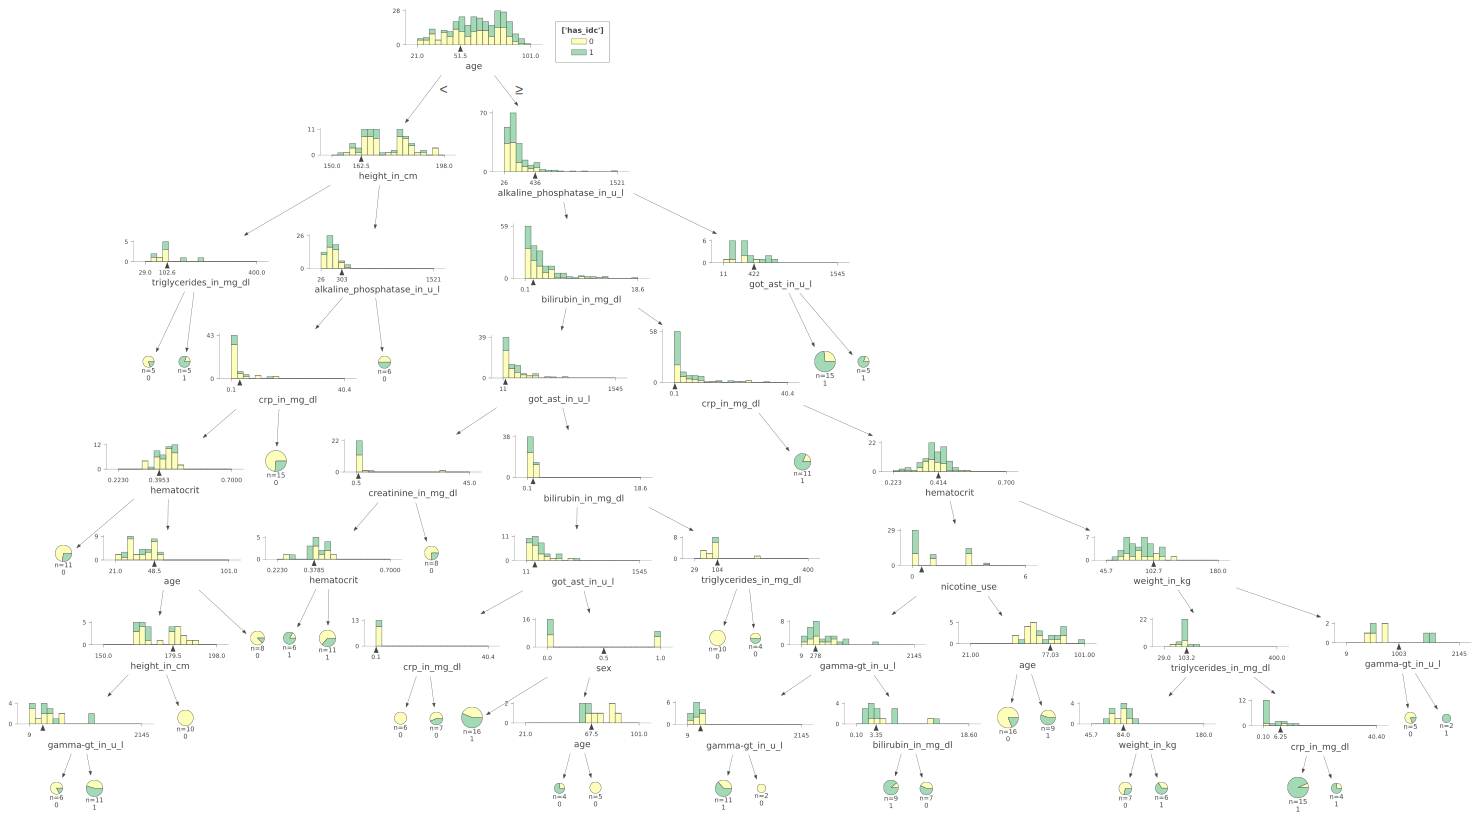

In [40]:
viz_cmodel.view()

##### First three levels of tree

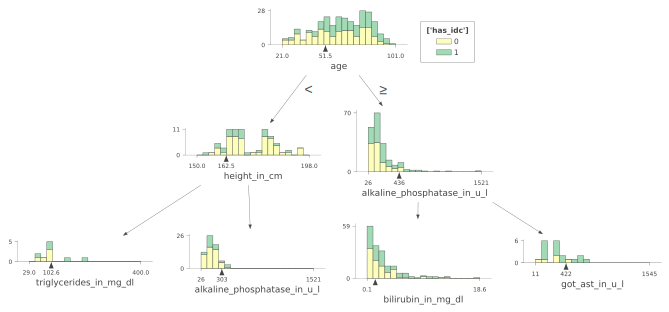

In [41]:
viz_cmodel.view(depth_range_to_display=[0,2])

##### Other plots

/opt/conda/lib/python3.11/site-packages/dtreeviz/models/shadow_decision_tree.py:335: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/opt/conda/lib/python3.11/site-packages/dtreeviz/trees.py:1231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


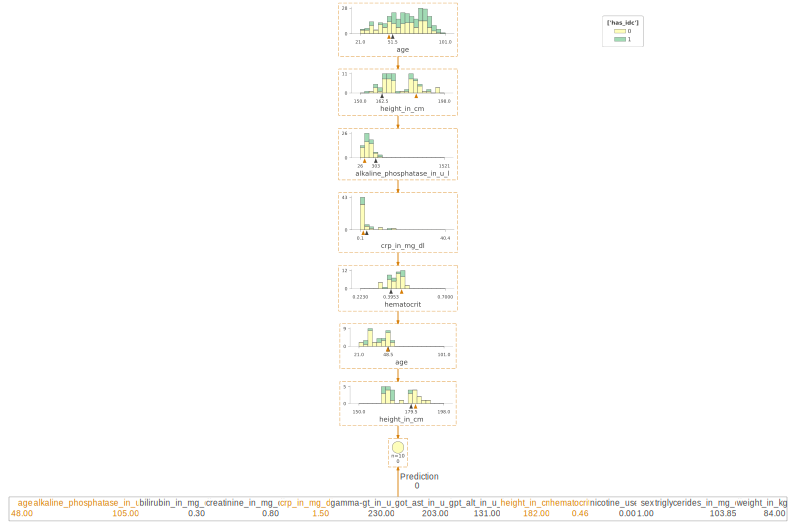

In [42]:
x = train_df_pd[model_features].iloc[0]
viz_cmodel.view(x=x, show_just_path=True, scale=.75)

In [43]:
train_df_pd.iloc[0]

has_idc                                        0.000000
sex                                            1.000000
nicotine_use                                   0.000000
age                                           48.000000
height_in_cm                                 182.000000
weight_in_kg                                  84.000000
crp_in_mg_dl                                   1.500000
bilirubin_in_mg_dl                             0.300000
got_ast_in_u_l                               203.000000
gpt_alt_in_u_l                               131.000000
gamma-gt_in_u_l                              230.000000
alkaline_phosphatase_in_u_l                  105.000000
triglycerides_in_mg_dl                       103.854095
hematocrit                                     0.455000
creatinine_in_mg_dl                            0.800000
clinical_data_stone_microlithiasis_sludge      1.000000
Name: 0, dtype: float64

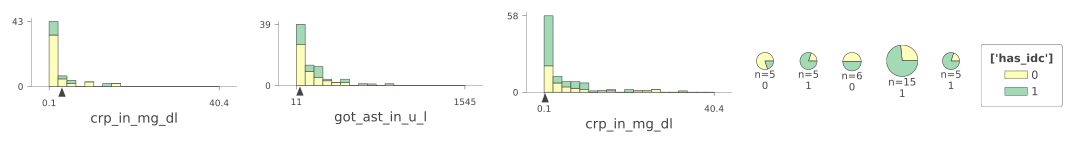

In [44]:
viz_cmodel.view(depth_range_to_display=[3,3], scale=1.5)

#### Plot the training logs

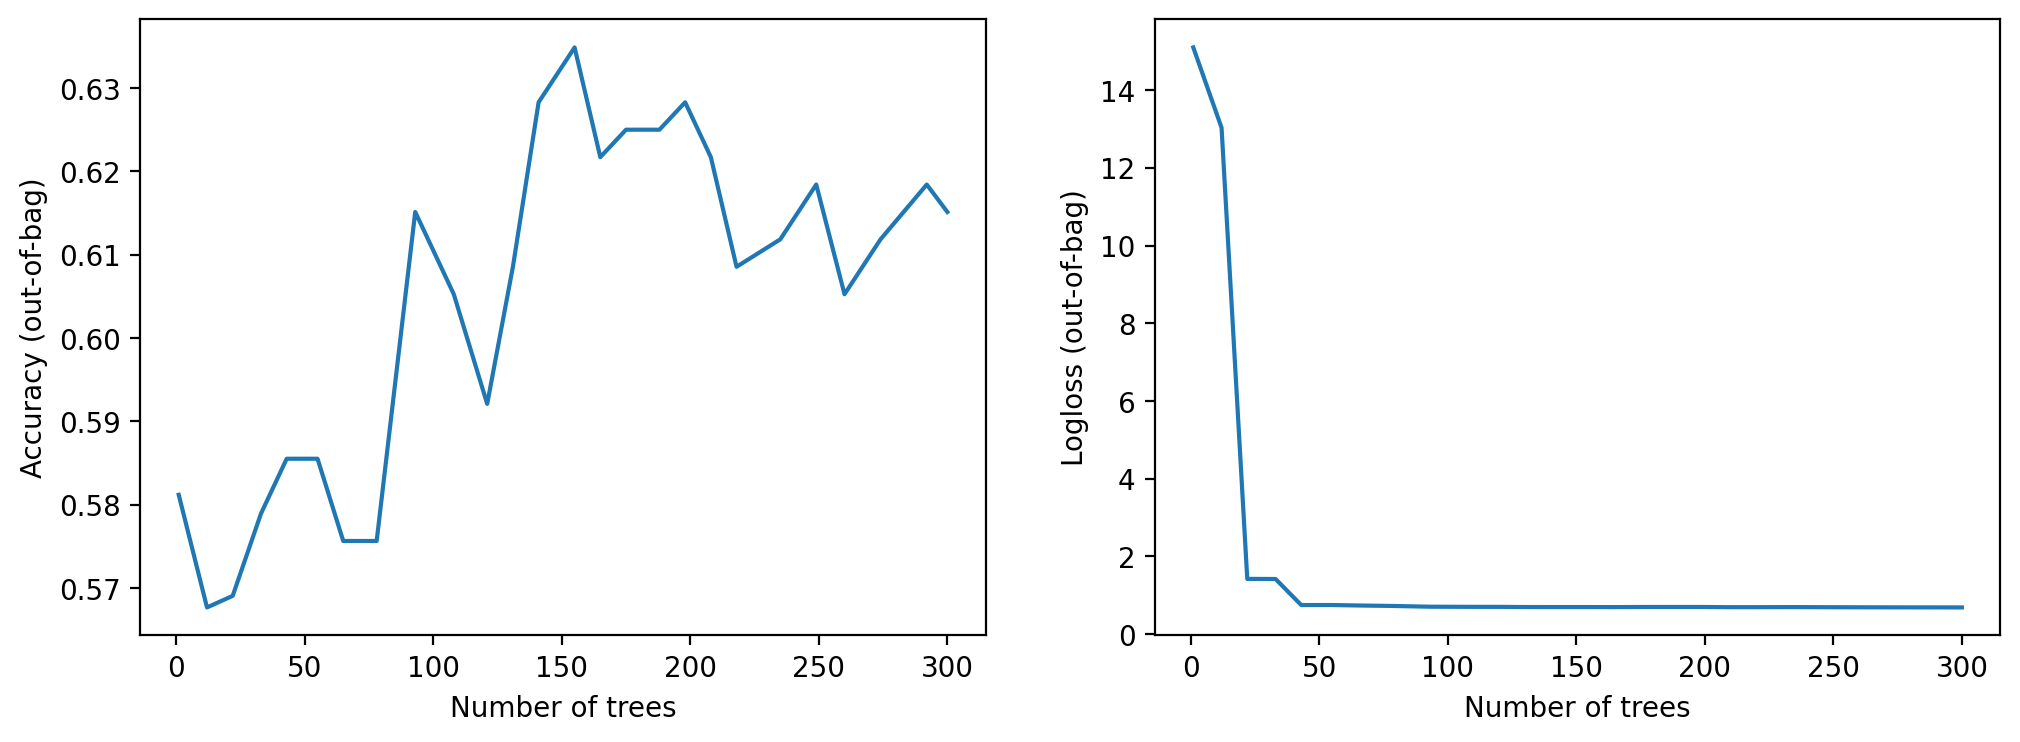

In [45]:
import matplotlib.pyplot as plt

logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

## Test data for TFDF: Day 3

### Features

#### Test the model on day 3

In [46]:
test_df_ecrp_gte_3_days.values

array([[ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [

1/1 [==============================] - 0s 36ms/step


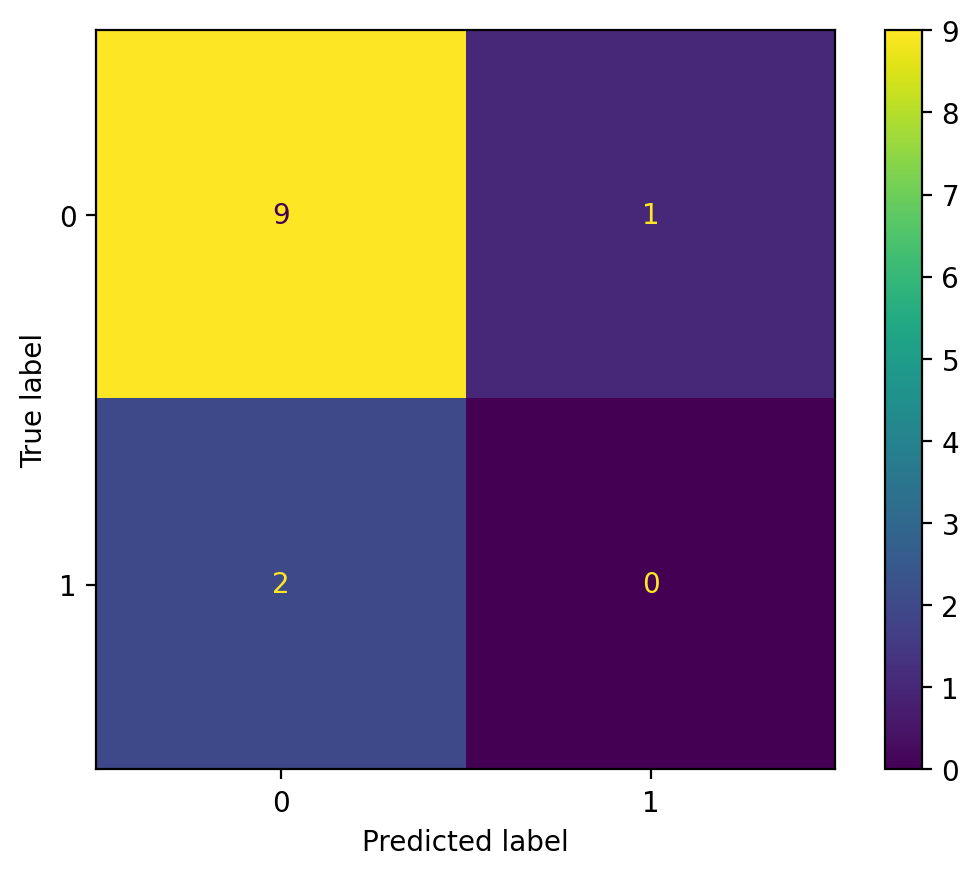

In [47]:
# Subset test_df_d3 for only preds == True and ecrp_gte_3_days == True
d3 = test_df_ecrp_gte_3_days.values
tp = (np.logical_and(d3 == True, preds == False))
test_df_d32_keras = tfdf.keras.pd_dataframe_to_tf_dataset(test_df_d32[tp], label="has_idc")


probs_d3 = model_rf.predict(test_df_d32_keras)

probs_d3 = probs_d3 > 0.3

probs_d3 = probs_d3.astype(int)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(test_labels[tp], probs_d3)




import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels[tp], probs_d3)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


**Figure.** This figure shows the patients who did not receive an ERCP within 3 days of admission and who were classfied as 'no IDC' on admission. Note: the number of cases with IDC is very low!

In [48]:
evaluation = model_rf.evaluate(test_df_d32_keras, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 199ms/step - loss: 0.0000e+00 - accuracy: 0.8333 - auc: 0.5000 - true_positives: 0.0000e+00 - true_negatives: 10.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
loss: 0.0000
accuracy: 0.8333
auc: 0.5000
true_positives: 0.0000
true_negatives: 10.0000
false_positives: 0.0000
false_negatives: 2.0000
